# Double Inverted Pendulum (DIP) modelling
***

## 1. Environment Setup
******

* Install Miniconda: https://docs.conda.io/en/latest/miniconda.html
* Navigate to where you want to store the repository
* Open terminal and execute: `git clone git@github.com:mughees-asif/dip.git`
* Install the environment requirements in the same directory through the installed miniconda terminal: `pip install do-mpc`
* Open this notebook through the miniconda terminal: `jupyter notebook`

__**You should now be set-up to run this example.**__

## 2. Model
*********

* Configuration
* Setup
* Connection

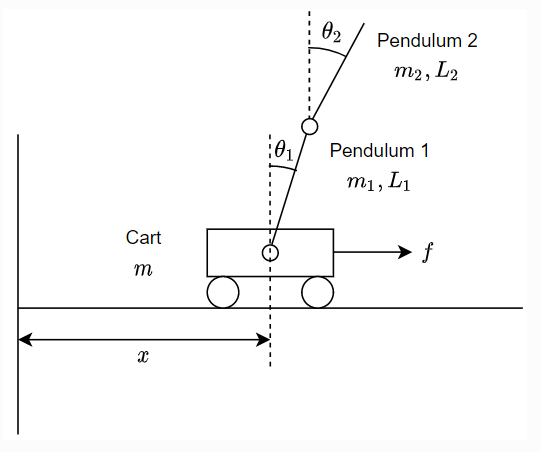

In [161]:
# necessary imports
import numpy as np
import sys
from casadi import *
import do_mpc

In [162]:
# system is described in terms of its horizontal position x and the two angles θ,
# where θ1=θ2=0 denotes the upright position.
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [163]:
# model parameters
m0 = 0.6  # kg, mass of the cart
m1 = 0.2  # kg_1, mass of the first rod
m2 = 0.2  # kg_2, mass of the second rod
L1 = 0.5  # m_1,  length of the first rod
L2 = 0.5  # m_2,  length of the second rod
g = 9.80665 # m/s^2, Gravity

In [164]:
# simplified parameters
l1 = L1/2 # m,
l2 = L2/2 # m,
J1 = (m1 * l1**2) / 3   # Inertia
J2 = (m2 * l2**2) / 3   # Inertia

h1 = m0 + m1 + m2
h2 = m1*l1 + m2*L1
h3 = m2*l2
h4 = m1*l1**2 + m2*L1**2 + J1
h5 = m2*l2*L1
h6 = m2*l2**2 + J2
h7 = (m1*l1 + m2*L1) * g
h8 = m2*l2*g

## 3. Euler-Lagrangian equations
*****
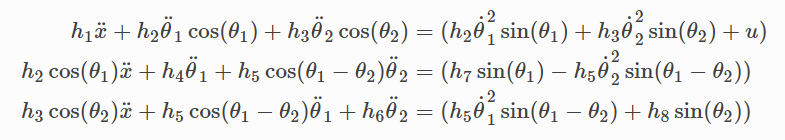

* Dynamics of the double pendulum

In [165]:
# Euler-Lagrangian equation parameter definition
pos = model.set_variable('_x',  'pos')
theta = model.set_variable('_x',  'theta', (2,1))
dpos = model.set_variable('_x',  'dpos')
dtheta = model.set_variable('_x',  'dtheta', (2,1))

# horizontal force
u = model.set_variable('_u',  'force')

In [166]:
# Differential algebraic equation (DAE): algebraic states that allow formulation 
# of the ODE in terms of {x, u, z}
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

In [167]:
# Euler-Lagrangian equations to define the dynamics of the double pendulum
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)

## 4. The energy equations
***

* Kinetic energy
* Potential energy
* Building the model

### 4.1. Kinetic energy
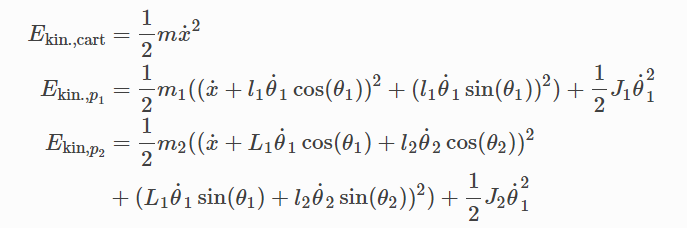

In [168]:
# kinectic energy equations
E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

### 4.2. Potential energy 
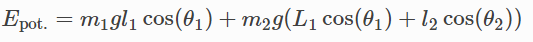

In [169]:
# potential energy equations
E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(((0.490333*cos(theta_0))+(1.96133*((0.5*cos(theta_0))+(0.25*cos(theta_1))))))

In [170]:
# build the model
model.setup()

## 5. Controller
***

* Prediction model

In [171]:
# instance of the MPC class
mpc = do_mpc.controller.MPC(model)

In [172]:
# prediction parameters
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

## 6. Objective
***

* Based on the energy equations
* Erect the double pendulum
* Stabilisation 

In [173]:
# the fomulation of the objective function
mterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.1)

## 6. Constraints
***

* Upper bound
* Lower bound
* Setup

In [174]:
# lower bound
mpc.bounds['lower','_u','force'] = -4
# upper bound
mpc.bounds['upper','_u','force'] = 4

In [175]:
# setup of the controller
mpc.setup()

## 7. Estimator
***

* State-feedback

In [176]:
estimator = do_mpc.estimator.StateFeedback(model)

## 8. Simulator
***

* Model Predictive Control (MPC) in a closed-loop

In [177]:
simulator = do_mpc.simulator.Simulator(model)

In [178]:
# parameters of the simulator
params_simulator = {
    'integration_tool': 'idas',
    'abstol': 1e-4,
    'reltol': 1e-4,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [179]:
# setup of the simulator
simulator.setup()

## 9. Closed-loop simulation
***

* Define initial state
* Setup the configuration
* Prepare visualisation using `matplotlib`
* Take input states to define position of ${x, y}$ at time $t$
* Graphics setup
* Run open-loop example to check validity of the visualisation
* Run closed-loop

In [180]:
# initial state
simulator.x0['theta'] = 0.99*np.pi

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [181]:
# matplotlin basic settings
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [182]:
# the current estimated state, the predicted trajectory of the 
# states and inputs based on the solution of the control problem. 
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [183]:
# retrieve input states
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([
        x[0],
        x[0]+L1*np.sin(x[1])
    ])

    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])

    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])

    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])

    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))

    return line_1, line_2

# graphics setup

In [184]:
%%capture

fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('$E_{kin}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

### 9.1. Open-loop example check

In [185]:
# setup
u0 = mpc.make_step(x0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19406
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     6814

Total number of variables............................:     4330
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4206
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  83 1.5456570e+002 1.77e-001 2.33e-001  -3.8 2.83e+002  -4.8 1.04e-001 3.27e-002h  1
  84 1.5440037e+002 1.44e-001 1.66e-001  -3.8 4.80e+001  -4.3 4.72e-001 3.36e-001h  1
  85 1.5407612e+002 2.49e-001 1.65e-001  -3.8 1.44e+002  -4.8 2.12e-001 2.59e-001h  1
  86 1.5371105e+002 4.04e-001 3.14e-001  -3.8 3.83e+002  -5.3 1.31e-001 1.26e-001h  1
  87 1.5361938e+002 3.69e-001 2.90e-001  -3.8 1.17e+002  -4.9 5.48e-001 1.03e-001h  1
  88 1.5316240e+002 5.61e-001 5.09e-001  -3.8 9.94e+002  -5.3 7.88e-002 6.80e-002f  1
  89 1.5309233e+002 1.53e-001 1.12e-001  -3.8 2.79e+001  -4.0 7.90e-001 7.26e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.5299821e+002 1.21e-001 8.12e-002  -3.8 5.49e+001  -4.5 1.00e+000 2.44e-001h  1
  91 1.5272112e+002 2.39e-001 2.69e-001  -3.8 2.84e+002  -5.0 4.16e-001 1.41e-001h  1
  92 1.5245325e+002 2.31e-001 2.68e-001  -3.8 8.00e+001  -4.5 1.00e+000 3.78e-001h  1
  93 1.5176265e+002 1.06e+000 7.94e-001  -3.8 2.83e+002  -5

 173 1.1413550e+002 2.99e+000 2.21e+000  -3.8 2.66e+002  -5.3 5.88e-001 1.00e+000h  1
 174 1.1273664e+002 6.35e+000 2.65e+000  -3.8 2.42e+002  -4.8 3.04e-001 1.00e+000h  1
 175 1.1110901e+002 1.12e+001 4.05e+000  -3.8 6.47e+002  -5.3 2.27e-001 7.33e-001h  1
 176 1.1141382e+002 1.04e+001 3.75e+000  -3.8 2.66e+002  -4.9 1.00e+000 7.75e-002h  1
 177 1.1197426e+002 8.00e+000 2.73e+000  -3.8 1.25e+002  -4.5 1.00e+000 2.49e-001h  1
 178 1.1220166e+002 4.75e+000 1.74e+000  -3.8 1.85e+002  -4.9 4.15e-001 4.16e-001h  1
 179 1.0936128e+002 3.26e+001 9.40e+000  -3.8 3.49e+003  -5.4 2.60e-002 1.73e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.0807747e+002 1.43e+001 7.18e+000  -3.8 1.33e+003  -5.9 7.75e-002 3.65e-001h  1
 181 1.0642474e+002 7.05e+001 2.84e+001  -3.8 1.39e+003  -6.4 5.98e-002 7.64e-001h  1
 182 1.0635288e+002 5.83e+001 2.35e+001  -3.8 4.09e+002  -6.8 1.83e-001 1.75e-001h  1
 183 1.0638589e+002 4.50e+001 1.84e+001  -3.8 4.47e+002  -7

 262 8.5977957e+001 9.98e-002 6.14e-001  -3.8 3.43e+001  -4.4 1.00e+000 7.30e-001h  1
 263 8.5769900e+001 1.60e-001 9.92e-001  -3.8 1.59e+002  -4.9 1.37e-001 1.63e-001h  1
 264 8.5531899e+001 9.88e-002 4.06e-001  -3.8 3.28e+001  -4.4 1.00e+000 1.00e+000h  1
 265 8.5219995e+001 1.75e-001 8.24e-001  -3.8 5.72e+001  -4.9 5.88e-001 7.38e-001h  1
 266 8.5078730e+001 1.63e-001 7.88e-001  -3.8 8.63e+001  -5.4 5.34e-001 1.95e-001h  1
 267 8.5044072e+001 1.59e-001 7.66e-001  -3.8 1.16e+002  -5.9 1.00e+000 3.79e-002h  1
 268 8.4764952e+001 3.35e-001 1.39e+000  -3.8 1.28e+002  -6.3 5.53e-001 3.48e-001h  1
 269 8.4452760e+001 5.59e-001 1.99e+000  -3.8 1.51e+002  -6.8 1.00e+000 4.25e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 8.4683213e+001 2.50e-002 2.72e-001  -3.8 2.95e+001  -4.6 1.00e+000 1.00e+000h  1
 271 8.4679587e+001 2.53e-002 2.64e-001  -3.8 4.47e+001  -5.1 1.00e+000 1.50e-001h  1
 272 8.4635876e+001 1.71e-001 1.44e+000  -3.8 2.65e+002  -5

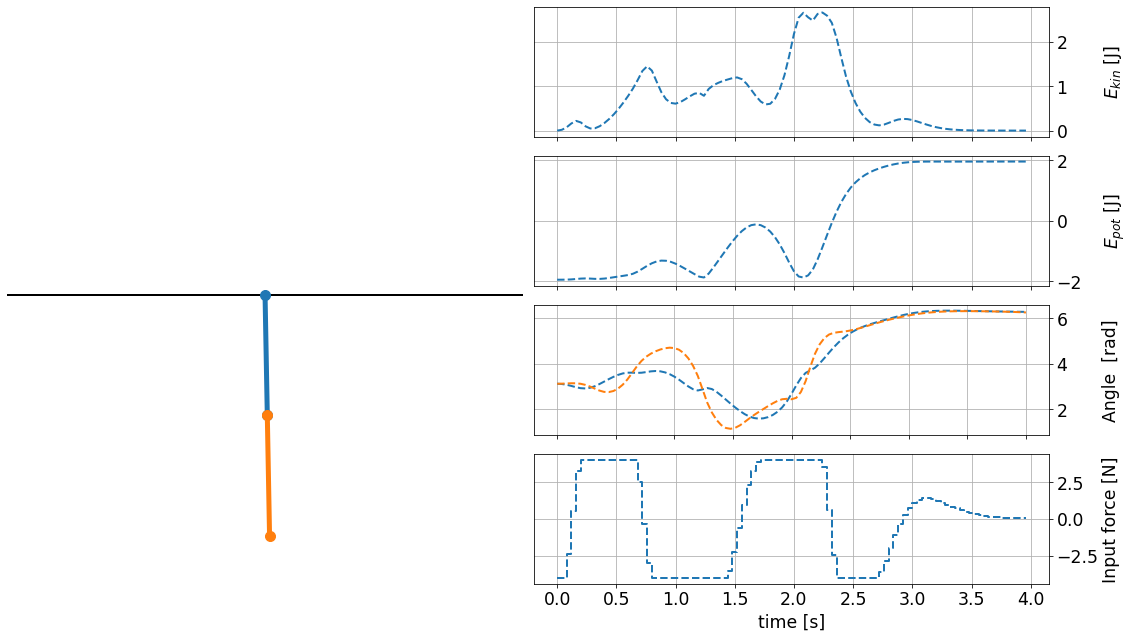

In [186]:
# visualisation of open-loop
line1, line2 = pendulum_bars(x0)
bar1[0].set_data(line1[0],line1[1])
bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

### 9.2. Closed-loop 

* Simulated for $100$ steps

In [187]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [188]:
# conversion to gif
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()

# save gif in root folder
anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
anim.save('anim_dip.gif', writer=gif_writer)